# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели "нейросети" (в варианте линейной регрессии) методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель "нейросети" (линейной регрессии) в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка всех составляющих модели "нейросети";
- формулировка модели "нейросети" - `NN` (линейной регрессии);
- формулировка функции ошибки вместе с ее составляющими (например, класс отклонения `Residual`);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределения признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.
- диаграмма соответствия измеренной целевой переменной и значений целевой переменной, оцененной с использованием обученной "нейросети"

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись. По ней можно сверить свой результат.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{G}{\mathscr{L}}\cdot\nabla_{\theta}{G}
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = 2\left(X\theta - Y\right) \cdot \mathbf{I} \cdot X
$$

В этом ДЗ следует очень аккуратно реализовать градиент каждой отдельной операции по аргументу этой операции:
- градиент квадрата отклонения $d^2$ - по отклонению $d$
- градиент отклонения $\left(\hat{y}-y\right)$ - по аргументу $\hat{y}$
- градиент функции активации $\hat{y}=A\left(z\right)$ - по ее агрументу $z$ (да, здесь функция активации $A$ - Identity, но это сейчас не так важно)
- градиент оценки $z=\theta^T\cdot X$ - по аргументу $\theta$

**ВНИМАНИЕ**
В этом задании также следует учесть, что подразумевается, что метод `backward` каждого класса выдает градиент **функции ошибки** по аргументу операции. Для учета градиентов всех предыдущих операций в этот метод передается т.н. **upstream gradient** - переменная `usg`. Не забывайте ее передавать при "сборке" полного градиента. Эта "сборка" у вас будет в двух классах - классе функции потерь `MSE` (нужно собрать градиент операции `MSE` с учетом того, что она, в свою очередь, сложная функция, использующая `Residual`) и классе нейросети `NN`.

Как можно видеть, все операции, из которых составляется "нейросеть" в этом задании, могут быть представлены однотипно: для всех из них можно задать метод вычисления `forward` на "прямом проходе" и метод вычисления градиента `backward` на этапе вычисления градиентов, "обратном проходе".

**ВНИМАНИЕ**
Не следует забывать, что для вычисления градиентов обычно используются результаты операции, вычисленные на этапе "прямого прохода". Для хранения этих результатов используйте атрибуты класса `cache`. Напомним, ссылка на сам экземпляр класса в теле метода класса обычно упоминается как `self`. То есть, атрибут `cache` этого экземпляра класса будет в этом методе упоминаться как `self.cache`. Вы можете назвать его как угодно (не обязательно именно `cache`), но реализация хранения промежуточных результатов вычисления нейросети - **обязательно** в этом ДЗ.

In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
Xtr = np.load('./X_train.npy')
ytr = np.load('./y_train.npy')

In [5]:
ytr.shape

(10000, 1)

In [6]:
Xtr.shape

(10000, 4)

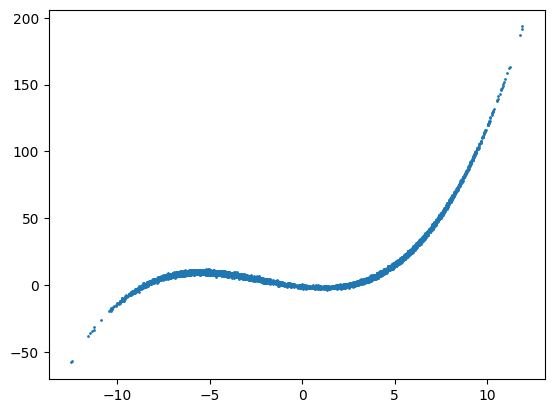

In [7]:
plt.scatter(Xtr[:,0], ytr, s=1)

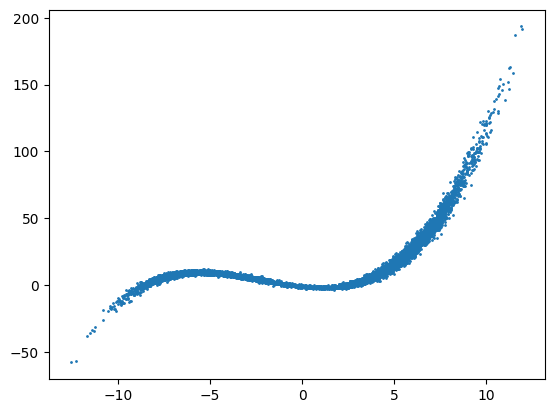

In [8]:
plt.scatter(Xtr[:,1], ytr, s=1)

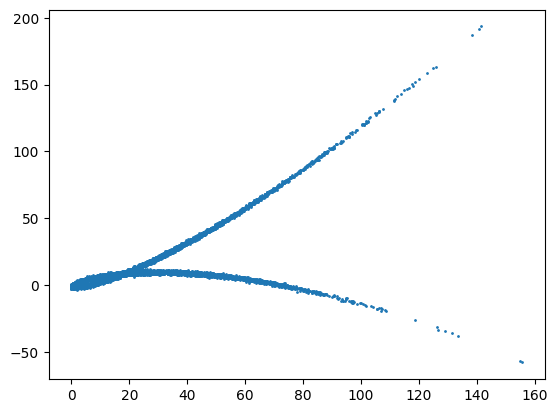

In [9]:
plt.scatter(Xtr[:,2], ytr, s=1)

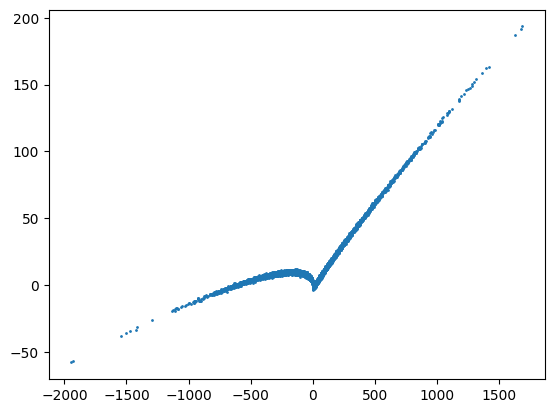

In [10]:
plt.scatter(Xtr[:,3], ytr, s=1)

In [11]:
np.corrcoef(Xtr, rowvar=False)

array([[1.        , 0.99930832, 0.00924955, 0.88100664],
       [0.99930832, 1.        , 0.0096915 , 0.88030952],
       [0.00924955, 0.0096915 , 1.        , 0.01899396],
       [0.88100664, 0.88030952, 0.01899396, 1.        ]])

<span style="color:orange">
    
### Решение о признаках ###
3 признак надо убрать, так как неоднозначность зависимости y от x. </br>
Первые 2 признака сильно скоррелированы 1 можно убрать.

In [12]:
# Примите решение о фильтрации признаков или порождении новых признаков
# Xtr1 = Xtr[:,[1,3]] 

In [13]:
# Xtr1.shape

In [14]:
# print(Xtr1)

In [15]:
# np.corrcoef(Xtr1, rowvar=False)

In [267]:
class Differentiable:
    def __init__(self):
        pass

    
    def forward(self, *args, **kwargs):
        raise NotImplementedError()

    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [268]:
class linear(Differentiable):
    def __init__(self):
        super(linear, self).__init__()
        self.theta = None
        self.cache = None

    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения целевой переменной
        return self.forward(X)

    
    def forward(self, X):
        # этот метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"

        # ВНИМАНИЕ! Матрица объекты-признаки X не включает смещение
        #           Вектор единиц для применения смещения нужно присоединить самостоятельно!
        
        ### YOUR CODE HERE
        # X_ = ...
        
        if (self.theta is None):
            # Если вектор параметров еще не инициализирован, его следует инициализировать
            # Подсказка: длина вектора параметров может быть получена из размера матрицы X
            # Fx1.T dot NxF.T = 1xN
            # Если X - матрица объекты-признаки, то это матрица из вектор-строк!
            self.theta = np.matrix(np.random.uniform(-1, 1, Xtr.shape[1] + 1))
        
        
        # Здесь следует собственно применить модель к входным данным
        
        ### YOUR CODE HERE
        # print(self.theta[:,-1], X.shape[1])
        mu = np.dot(self.theta[:,:-1], np.transpose(X)) + self.theta[:,-1]
        self.cache = X
        
        return mu

    
    def backward(self, usg):
        # Этот метод реализует вычисление компоненты градиента функции потерь
        
        assert self.cache is not None, "please perform forward pass first"
        
        ### YOUR CODE HERE
        partial_grad = np.column_stack((self.cache, np.array([1] * self.cache.shape[0])))
        partial_grad = np.matmul(usg, partial_grad)
        
        # Не забудьте очистить кэш!
        self.cache = None
        
        return partial_grad

In [269]:
np.diag([-1]*3, k=0)

array([[-1,  0,  0],
       [ 0, -1,  0],
       [ 0,  0, -1]])

In [270]:
class Residual(Differentiable):
    def __init__(self):
        super(Residual, self).__init__()

    
    def __call__(self, mu, y):
        return self.forward(mu, y)

    
    def forward(self, mu, y):
        # Этот метод реализует вычисление отклонения mu-y
        # print('11', mu.shape)
        # print('12', y.shape)
        d = np.subtract(mu, np.transpose(y))
        self.cache = d
        # print('13', d.shape)

        # 1*N
        return d

    
    def backward(self, usg):
        # Этот метод реализует вычисление градиента отклонения D по аргументу mu
        
        ### YOUR CODE HERE
        # partial_grad = np.diag([-1]*self.cache.shape[1], k=0)
        # partial_grad = np.matmul(usg, partial_grad)
        partial_grad = -usg
        return partial_grad

In [271]:
class MSE(Differentiable):
    def __init__(self):
        super(MSE, self).__init__()
        
    
    def __call__(self, d):
        return self.forward(d)
        
    
    def forward(self, d):
        # Этот метод реализует вычисление значения функции потерь
        # Подсказка: метод должен возвращать единственный скаляр - значение функции потерь
        self.cache = d
        mse_value = np.divide(np.sum(np.square(d)), len(d))
        
        return mse_value
    
    
    def backward(self):
        # Этот метод реализует вычисление градиента функции потерь по аргументу d
        # Подсказка: метод должен возвращать вектор градиента функции потерь
        #           размерностью, совпадающей с размерностью аргумента d
        
        
        ### YOUR CODE HERE
        n = 2 / (self.cache.shape[1])
        partial_grad = n * self.cache
        # self.cache = None
        # print('5', partial_grad.shape)

        # 1*N
        return partial_grad
        

In [272]:
class Identity(Differentiable):
    def __init__(self):
        super(Identity, self).__init__()
    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения функции активации
        return self.forward(X)
    
    def backward(self, usg):
        # Этот метод реализует вычисление компоненты градиента функции потерь
        return usg
    
    def forward(self, X):
        # этот метод предназначен для вычисления функции активации
        return X

In [273]:
class NN(Differentiable):
    def __init__(self):
        super(NN, self).__init__()
        self.l1 = linear()
        self.act = Identity()

    
    def __call__(self, X):
        return self.forward(X)

    
    def forward(self, X):
        # Этот метод будет вычислять нейросеть на данных X
        ### YOUR CODE HERE
        x = self.l1(X)
        # print('1', x)
        x = self.act(x)
        # print('2', x)
        
        return x

    
    def backward(self, usg):
        grad = None
        ### YOUR CODE HERE
        grad = self.act.backward(usg)
        # print('3', grad.shape)
        grad = self.l1.backward(grad)
        # print('4', grad.shape)
        return grad

In [274]:
class Loss(Differentiable):
    def __init__(self):
        super(Loss, self).__init__()
        self.dev = Residual()
        self.mse = MSE()
    
    def __call__(self, mu, y):
        return self.forward(mu, y)
    
    def forward(self, mu, y):
        # Этот метод будет вычислять нейросеть на данных X
        ### YOUR CODE HERE
        d = self.dev(mu, y)
        l = self.mse(d)
        return l
    
    # def backward(self, usg):
    def backward(self):
        grad = None
        ### YOUR CODE HERE
        grad = self.mse.backward()
        # print('1', grad.shape)
        grad = self.dev.backward(grad)
        # print('2', grad.shape)
        
        return grad

In [275]:
def clip_by_norm(grad, max_norm = 1.0):
    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_norm:
        grad = max_norm * grad / grad_norm
    return grad

In [276]:
network = NN()

In [277]:
mu = network(Xtr)

In [278]:
loss_fn = Loss()

In [279]:
loss_value = loss_fn(mu, ytr)

In [280]:
loss_fn.backward()

matrix([[0.00124136, 0.00329199, 0.00381424, ..., 0.00402313, 0.00414398,
         0.02473593]])

In [281]:
grad = network.backward(usg=loss_fn.backward())

In [287]:
learning_rate = 1e-4
epochs = 10000

### Далее идет процедура обучения созданной нейросети

In [288]:
loss_history = []
pbar = tqdm(total=epochs)
for epoch in range(epochs):
    # mu = None
    # loss_value = None
    # grad = None
    # grad = clip_by_norm(grad, 1.0)
    
    ### YOUR CODE HERE
    mu = network(Xtr)
    loss_value = loss_fn(mu, ytr)
    grad = network.backward(usg=loss_fn.backward())
    grad = clip_by_norm(grad, 10)
    
    # update network parameters
    network.l1.theta = network.l1.theta + learning_rate * grad
    # print(network.l1.theta)
    loss_history.append(loss_value)
    pbar.update(1)
    pbar.set_postfix({'loss': loss_value})
pbar.close()

100%|█| 10000/10000 [00:29<00:00, 342.57it/s, loss=9


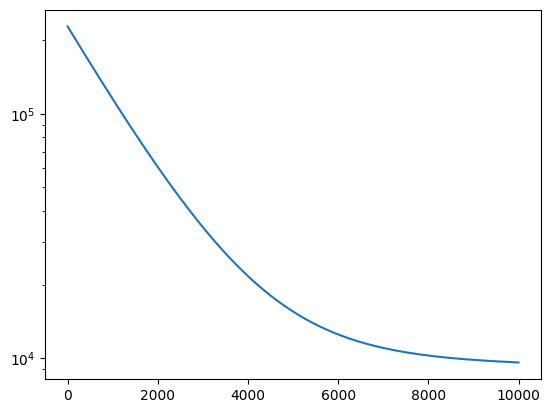

In [289]:
# отобразите эволюцию функции потерь по мере обучения сети
plt.plot(loss_history)
plt.yscale('log')

In [290]:
# примените нейросеть к данным Xtr
mu = network(Xtr)

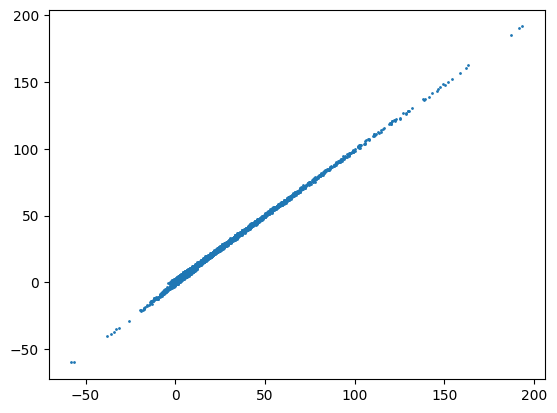

In [291]:
# отобразите диаграмму y(y_true) для оценки соответствия полученного решения известному
plt.scatter(list(ytr), list(mu), s=1)